# Using the Crossref API

[Crossref](https://www.crossref.org/) provides an API to get the references of a publication.

https://github.com/CrossRef/rest-api-doc


- A first idea is to go down the references for a fixed number of steps (for example 3), then keep only the articles which have been visited more than N times (for examples 3 times), and draw the upward graph starting from these articles. 
- Second idea: to look a the top cited articles in the creates graph

## to do:
- export the graph to Gephi...

- color the graph using descendance

- cluster by removing nodes from the right, sens of a non-direct graph?  min-cut

- stats:  n ref vs n citation, review vs foundational

- disconnected component for the 1st generation references: coloring 

### Knowledge reduction

- ne pas afficher les references, si au moins une des references l'utilise
- supprime un lien si un chemin plus long existe




In [404]:
import explorerefs as exp

169 articles loaded from cache


In [347]:
import requests
import pickle
import time

In [363]:
cachefilename = "crossref_cache.pickle"

try:
    with open(cachefilename, 'rb') as f:
        requesteddoi = pickle.load(f)
except:
    requesteddoi = {}
    
print( len(requesteddoi), 'articles in cache' )

167 articles in cache


In [399]:
def requestDoi(doi):
    """ Return the data for a given DOI
        - look first in the dictionary requesteddoi
        - if no data send the request to https://api.crossref.org/
    """
    if doi in requesteddoi:
        return requesteddoi[doi]
    else:
        url = 'https://api.crossref.org/works/'
        time.sleep(1)
        params = { 'mailto':'xdze2.me@gmail.com'}
        response = requests.get(url+doi, params=params)
        
        if not response.ok:
            print('query error')
            return None
        else:
            response = response.json()
            message = response['message']
            
            requesteddoi[doi] = message
            
            # save to file
            with open(cachefilename, 'wb') as f:
                pickle.dump(requesteddoi, f)
                
            return message

        
def getRefList(doi):
    """ Return the list of reference for which a doi is specified
        for the article doi
    """
    message = requestDoi(doi)
    references = message.get('reference', [])
    referencesWithDoi = { ref['DOI'] for ref in references if 'DOI' in ref }
    # print(doi, len(referencesWithDoi))
    return list( referencesWithDoi )


def printInfo(doi):
    """ Print info about a article
    """
    message = requestDoi(doi)
    doi = message['DOI']
    title = message['title'][0].split(' ')
    if len(title)>8:
        title.insert(8, '\n')
    title = ' '.join( title )
    
    authors = '; '.join( ['{given} {family}'.format( **auth ) for auth in message['author'] ] )
    year = message['issued']['date-parts'][0][0]
    print( "[{DOI}] {title}".format( DOI=message['DOI'], title=title ) )
    print(  authors, '-', message['container-title'][0], '-', year )
    print( 'nbr de refs: ', len(message.get('reference', []) ), '- with doi:', len(getRefList(doi)) )

    
    
def getRandomDOI( N=10 ):
    """ Obtain a random sampling from crossref
        of N doi
    """
    url = 'https://api.crossref.org/works/'
    time.sleep(1)
    params = { 'mailto':'xdze2.me@gmail.com',
                'sample': str(N),
                'select':'DOI,title' }
    response = requests.get(url, params=params)
    response = response.json()
    
    response = response['message']['items']
    
    return [ (d['DOI'], d.get('title', '')) for d in response  ]

def getOneRandomDoi():
    r = getRandomDOI( N=1 )
    print( r[0][1] )
    return r[0][0]

In [402]:
doi = getOneRandomDoi()
printInfo(doi)

["Converting Traditional Materials Labs to Project-based Learning Experiences: Aiding students' Development of Higher-order Cognitive Skills"]
[10.1557/proc-1046-w03-03] Converting Traditional Materials Labs to Project-based Learning Experiences: 
 Aiding students' Development of Higher-order Cognitive Skills
Linda Vanasupa; Katherine C Chen; Jonathan Stolk; Richard Savage; Trevor Harding; Blair London; William Hughes - MRS Proceedings - 2007
nbr de refs:  10 - with doi: 6


In [367]:
doi = '10.1063/1.1722034' 
#doi = "10.1063/1.1654632"
doi = "10.2307/1592275"
printInfo(doi)

[10.2307/1592275] Divergent Antibody Responses to Vaccines and Divergent Body 
 Weights of Chicken Lines Selected for High and Low Humoral Responsiveness to Sheep Red Blood Cells
H. K. Parmentier; M. G. B. Nieuwland; E. Rijke; G. De Vries Reilingh; J. W. Schrama - Avian Diseases - 1996
nbr de refs:  0 - with doi: 0


In [265]:
#  ! pip install graphviz
# https://graphviz.readthedocs.io/en/stable/
# https://graphviz.gitlab.io/_pages/doc/info/attrs.html
from graphviz import Digraph
from IPython.display import Image, display, SVG

In [403]:
class Referencesgraph():
    """ Object to explore the reference graph
        starting from one article 
    """
    
    def __init__(self, doi):
        self.nodes = {doi:{ 'gen':0, 'citedBy':[] } }
        self.len = len( self.nodes )
    
    
    def grow(self):
        """ Expand the graph by including all the references papers
            i.e. expand one generation
        """
        nodes = self.nodes
        lastGen = self.lastGen()
        lastGenNodes = [ doi for doi, info in nodes.items() if info['gen']==lastGen ]
        
        for i, doi in enumerate( lastGenNodes ):
            print('{}/{} fetch %s'.format( i, len(lastGenNodes), doi ), end='\r')
            references = getRefList(doi)
            
            self.nodes[doi]['refs'] = references
            for ref in references:
                if ref not in self.nodes:
                    self.nodes[ref] = {'gen':lastGen+1, 'citedBy':[doi] }
                else:
                    self.nodes[ref]['citedBy'].append( doi )
                
        print('- done -' + ' '*10 )
        self.len = len( self.nodes )
                   
            
    def lastGen(self):
        """ Number of the last generation of the graph 
        """
        nodes = self.nodes
        return max( n['gen'] for n in nodes.values() )
    
    
    
    def degree(self, node):
        return len( self.nodes[node].get('refs', []) ) + len( self.nodes[node].get('citedBy', []) )
        
        
    def nodesVisitedTwice(self, N=2):
        """ List of nodes visited at least twice (N times)
        """
        isVisitedTwice = lambda node: len(node.get('citedBy', []))>=N
        return [ doi for doi, node in self.nodes.items() if isVisitedTwice(node) ]

        
    def printstats(self):
        print( 'nbre nodes: {}\nlast gen: {}'.format(self.len, self.lastGen() ) )
        

## Create the graph

In [267]:
doi = "10.1063/1.1654632"
doi = "10.1038/s41528-018-0030-4"
#doi = "10.1063/1.3284082"
doi = '10.1038/nmat1350'
refgraph = Referencesgraph(doi)

In [268]:
refgraph.nodes

{'10.1038/nmat1350': {'citedBy': [], 'gen': 0}}

In [271]:
refgraph.grow()

refgraph.printstats()

- done -          
nbre nodes: 481
last gen: 3


In [303]:
refgraph.nodesVisitedTwice(N=8)

['10.1103/PhysRevLett.21.1450', '10.1016/0022-3093(70)90091-8']

In [304]:
def buildlabel(doi):
    info = requestDoi( doi )
    year = info['issued']['date-parts'][0][0]
    familyname = [ auth['family'] for auth in info['author'] if auth['sequence']=='first'][0]

    key = familyname+str(year)
    return key

def parsedoi(doi):
    # bug graphviz
    doi = doi.replace(':', '')
    return doi

In [321]:
# Keep the nodes only cited more than N times
# and the citing articles

N = 7
nodesToCheck = refgraph.nodesVisitedTwice(N=N)
nodesToDraw = []
linksToDraw = []
while nodesToCheck:
    doi = nodesToCheck.pop()
    nodesToDraw.append(doi)
    
    for citing in refgraph.nodes[doi]['citedBy']:
        
        linksToDraw.append( (doi, citing) )
        if citing not in nodesToDraw and citing not in nodesToCheck:
            nodesToCheck.append( citing )

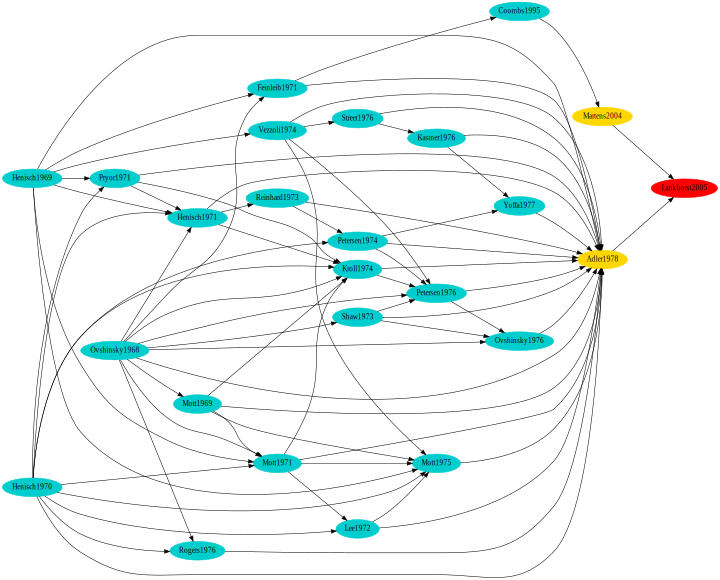

In [322]:
# -- Use Graphviz to draw the graph --
colorGen = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2']
# see https://graphviz.gitlab.io/_pages/doc/info/colors.html

DG = Digraph(comment='hello', format='svg', engine='dot' , graph_attr={'size':'10' })#})'root':doi} )
DG.graph_attr['rankdir'] = 'LR'

for doi in nodesToDraw:
    info =  refgraph.nodes[doi]
    DG.node(parsedoi(doi), color=colorGen[info['gen']], style='filled', label= buildlabel(doi))
    
for source, target in linksToDraw:
    DG.edge(parsedoi(source), parsedoi(target))  

plt = SVG(DG.render())
display(plt)

## Stats

In [323]:
from collections import Counter

In [324]:
citedByCount = Counter( { doi:len(info['citedBy']) for doi, info in refgraph.nodes.items() } )

In [325]:
for doi, count in citedByCount.most_common(4):
    printInfo( doi )
    print('')

[10.1103/physrevlett.21.1450] Reversible Electrical Switching Phenomena in Disordered Structures
Stanford R. Ovshinsky - Physical Review Letters - 1968
nbr de refs:  5

[10.1016/0022-3093(70)90091-8] A qualitative theory of electrical switching processes in 
 monostable amorphous structures
H.K. Henisch; E.A. Fagen; S.R. Ovshinsky - Journal of Non-Crystalline Solids - 1970
nbr de refs:  0

[10.1038/scientificamerican1169-30] Amorphous-Semiconductor Switching
H. K. Henisch - Scientific American - 1969
nbr de refs:  0

[10.1016/0022-3093(72)90189-5] Electrothermal switching in amorphous semiconductors
Theodore Kaplan; David Adler - Journal of Non-Crystalline Solids - 1972
nbr de refs:  0



# Famille

In [326]:
#nodesToDraw
#linksToDraw

In [327]:
cited = { target for source, target in linksToDraw }

In [328]:
roots = [ node for node in nodesToDraw if node not in cited ]
print( len(roots) )

3


In [329]:
upwardnodes = {}
for source, target in linksToDraw:
    if source in upwardnodes:
        upwardnodes[source].append( target )
    else:
        upwardnodes[source] = [ target ]
        
# add the summit
for node in nodesToDraw:
    if node not in upwardnodes:
        upwardnodes[node] = []

In [330]:
roots

['10.1038/scientificamerican1169-30',
 '10.1016/0022-3093(70)90091-8',
 '10.1103/PhysRevLett.21.1450']

In [331]:
origins = {}
toVisit = [ [r, r]  for r in  roots  ]

while toVisit:
    node, origin = toVisit.pop()
    
    if node in origins:
        origins[node].add( origin )
    else:
        origins[node] = set( [origin] )
       
    for target in upwardnodes[node]:
        toVisit.append((target, origin))
        
origins = { doi: ' '.join(sorted(oriSet)) for doi, oriSet in origins.items() }

In [332]:
len( origins ), len( upwardnodes )

(25, 25)

In [333]:

colorGen = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2', 'lightsalmon2', 'orchid',
            'springgreen2', 'sienna2', 'tomato', 'olivedrab', 'orange1', 'lightsteelblue', 'lightgray', 
           'crimson', 'azure2']

colorGen = colorGen + colorGen*3
colorOrigin = {  ori:col for  ori, col in zip( list( set( origins.values() ) ), colorGen) }


In [334]:
len(colorGen), len(set( origins.values() ))

(64, 7)

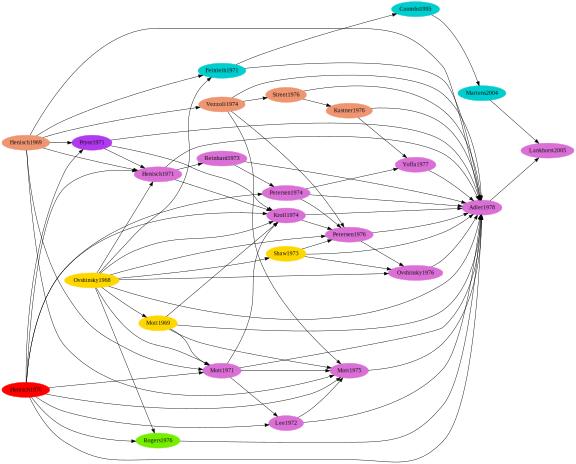

In [335]:
# -- Use Graphviz to draw the graph --
colorGen = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2', 'lightsalmon2', 'orchid']
# see https://graphviz.gitlab.io/_pages/doc/info/colors.html

DG = Digraph(comment='hello', format='svg', engine='dot' , graph_attr={'size':'8' })#})'root':doi} )
DG.graph_attr['rankdir'] = 'LR'

for doi in nodesToDraw:
    info =  refgraph.nodes[doi]
    color = colorOrigin[  origins[doi] ]
    DG.node(parsedoi(doi), color=color, style='filled', label= buildlabel(doi))
    
for source, target in linksToDraw:
    DG.edge(parsedoi(source), parsedoi(target))  

plt = SVG(DG.render())
display(plt)

## Draft

In [300]:
import networkx as nx

G = nx.DiGraph()
for source, target in AllGenRefs:
    
    if outDegree[source]>0:
        G.add_edge(source, target) 

nx.drawing.draw(G) 

NameError: name 'AllGenRefs' is not defined